# Screening Tasks

## Task 1 State VectorStatevector simulation of quantum circuits

### (1) Naive simulation using matrix multiplication

In [1]:
import numpy as np

# implement single qubit gates
I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

H = (1/np.sqrt(2)) * np.array([[1,  1],
                               [1, -1]], dtype=complex)

# implement CNOT gate
CNOT = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]], dtype=complex)

In [2]:
def initialize_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state

In [3]:
def apply_single_qubit_gate(state, gate, target_qubit, n):
    # apply single qubit gate to target qubit
    gates = []
    for i in range(n):
        if i == target_qubit:
            gates.append(gate)
        else:
            gates.append(I)
    full_gate = gates[0]
    for g in gates[1:]:
        full_gate = np.kron(full_gate, g)

    return full_gate @ state

def apply_cnot_gate(state, control_qubit, target_qubit, n):
    # apply CNOT gate to control qubit and target qubit
    if n != 2:
        raise NotImplementedError("Only 2 qubit CNOT gate is implemented")
    return CNOT @ state

In [4]:
import time
import matplotlib.pyplot as plt

def simulate_circuit(n, gate_sequence):
    state = initialize_state(n)
    for gate_info in gate_sequence:
        gate_type = gate_info['gate']
        if gate_type == 'H':
            state = apply_single_qubit_gate(state, H, gate_info['target'], n)
        elif gate_type == 'X':
            state = apply_single_qubit_gate(state, X, gate_info['target'], n)
        elif gate_type == 'CNOT':
            state = apply_cnot_gate(state, gate_info['control'], gate_info['target'], n)
        else:
            raise ValueError("Unknown gate type")
    return state

# example
gate_sequence = [
    {'gate': 'H', 'target': 0},
    {'gate': 'CNOT', 'control': 0, 'target': 1}
]


In [5]:
def test_runtime(max_qubits):
    qubit_counts = range(1, max_qubits + 1)
    runtimes = []
    for n in qubit_counts:
        # define a sequence of Hadamard gates on each qubit
        gate_sequence = [{'gate': 'H', 'target': i} for i in range(n)]
        start_time = time.time()
        state = simulate_circuit(n, gate_sequence)
        end_time = time.time()
        runtimes.append(end_time - start_time)
        print(f"Simulated {n} qubits in {end_time - start_time:.4f} seconds")
    # plot runtime vs number of qubits
    plt.figure(figsize=(10, 6))
    plt.plot(qubit_counts, runtimes, marker='o')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime vs Number of Qubits for Naive Simulation')
    plt.grid(True)
    plt.show()

In [ ]:
# measure runtime for 1 to 15 qubits
test_runtime(15)

Simulated 1 qubits in 0.0003 seconds
Simulated 2 qubits in 0.0004 seconds
Simulated 3 qubits in 0.0001 seconds
Simulated 4 qubits in 0.0002 seconds
Simulated 5 qubits in 0.0006 seconds
Simulated 6 qubits in 0.0016 seconds
Simulated 7 qubits in 0.0022 seconds
Simulated 8 qubits in 0.0052 seconds
Simulated 9 qubits in 0.0224 seconds
Simulated 10 qubits in 0.0673 seconds
Simulated 11 qubits in 0.2918 seconds
Simulated 12 qubits in 1.3987 seconds
Simulated 13 qubits in 5.9348 seconds
Simulated 14 qubits in 30.0301 seconds


### (2) Advanced simulation using tensor multiplication

In [6]:
def initialize_state_tensor(n):
    # Initialize a tensor of shape (2, 2, ..., 2) with all zeros
    state = np.zeros([2] * n, dtype=complex)
    # Set the |0...0> state to 1
    state[tuple([0] * n)] = 1.0
    return state

In [7]:
def apply_single_qubit_gate_tensor(state, gate, target_qubit):
    # Move the target qubit to the first axis
    state = np.moveaxis(state, target_qubit, 0)
    # Apply the gate using tensordot
    state = np.tensordot(gate, state, axes=([1], [0]))
    # Move the target qubit back to its original position
    state = np.moveaxis(state, 0, target_qubit)
    return state

def apply_cnot_gate_tensor(state, control_qubit, target_qubit, n):
    if n != 2:
        raise NotImplementedError("Currently, CNOT gate tensor application is only implemented for 2 qubits.")
    
    # Reshape the state tensor to a 4-element vector for 2 qubits
    state = state.reshape(2, 2)
    # Apply CNOT gate
    state = CNOT @ state.flatten().reshape(-1, 1)
    # Reshape back to tensor
    state = state.reshape(2, 2)
    return state

In [8]:
def simulate_circuit_tensor(n, gate_sequence):
    # Initialize the state tensor
    state = initialize_state_tensor(n)
    
    for gate_info in gate_sequence:
        gate_type = gate_info['gate']
        if gate_type in ['H', 'X']:
            # Apply single-qubit gate
            target = gate_info['target']
            gate = H if gate_type == 'H' else X
            state = apply_single_qubit_gate_tensor(state, gate, target)
        elif gate_type == 'CNOT':
            # Apply CNOT gate
            control = gate_info['control']
            target = gate_info['target']
            state = apply_cnot_gate_tensor(state, control, target, n)
        else:
            raise ValueError("Unknown gate type")
    return state

In [9]:
def test_runtime_tensor(max_qubits):
    qubit_counts = range(1, max_qubits + 1)
    runtimes = []
    
    for n in qubit_counts:
        # Define a simple circuit: apply Hadamard gate to all qubits
        gate_sequence = [{'gate': 'H', 'target': i} for i in range(n)]
        
        # Start timing
        start_time = time.time()
        
        try:
            state = simulate_circuit_tensor(n, gate_sequence)
            end_time = time.time()
            runtime = end_time - start_time
            runtimes.append(runtime)
            print(f"Simulated {n} qubits in {runtime:.4f} seconds")
        except MemoryError:
            print(f"MemoryError: Unable to simulate {n} qubits.")
            runtimes.append(None)
        except NotImplementedError as e:
            print(f"NotImplementedError: {e} for {n} qubits.")
            runtimes.append(None)
    
    # Plot runtime
    plt.figure(figsize=(10, 6))
    plt.plot(qubit_counts, runtimes, marker='o')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime vs Number of Qubits for Tensor Multiplication Simulation')
    plt.grid(True)
    plt.show()

Simulated 1 qubits in 0.0001 seconds
Simulated 2 qubits in 0.0001 seconds
Simulated 3 qubits in 0.0000 seconds
Simulated 4 qubits in 0.0001 seconds
Simulated 5 qubits in 0.0001 seconds
Simulated 6 qubits in 0.0001 seconds
Simulated 7 qubits in 0.0001 seconds
Simulated 8 qubits in 0.0002 seconds
Simulated 9 qubits in 0.0001 seconds
Simulated 10 qubits in 0.0001 seconds
Simulated 11 qubits in 0.0002 seconds
Simulated 12 qubits in 0.0005 seconds
Simulated 13 qubits in 0.0008 seconds
Simulated 14 qubits in 0.0015 seconds
Simulated 15 qubits in 0.0033 seconds
Simulated 16 qubits in 0.0070 seconds
Simulated 17 qubits in 0.0176 seconds
Simulated 18 qubits in 0.0341 seconds
Simulated 19 qubits in 0.0680 seconds
Simulated 20 qubits in 0.1504 seconds
Simulated 21 qubits in 0.4180 seconds
Simulated 22 qubits in 0.8798 seconds
Simulated 23 qubits in 1.8084 seconds
Simulated 24 qubits in 3.7291 seconds
Simulated 25 qubits in 8.1973 seconds


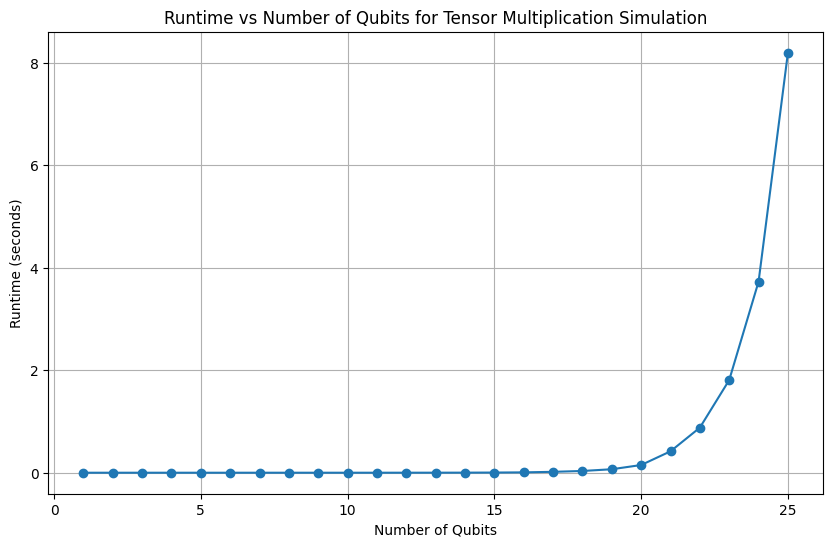

In [ ]:
test_runtime_tensor(25)

In [10]:
def test_runtime_comparison(max_qubits):
    """
    Compare the runtime of naive and tensor multiplication simulation methods.
    """
    qubit_counts = range(1, max_qubits + 1)
    runtimes_naive = []
    runtimes_tensor = []

    for n in qubit_counts:
        # Define a simple circuit: apply Hadamard gate to all qubits
        gate_sequence = [{'gate': 'H', 'target': i} for i in range(n)]

        # Naive Simulation
        start_time = time.time()
        try:
            _ = simulate_circuit_matrix(n, gate_sequence)
            end_time = time.time()
            runtime = end_time - start_time
            runtimes_naive.append(runtime)
            print(f"Matrix: Simulated {n} qubits in {runtime:.4f} seconds")
        except MemoryError:
            print(f"Matrix: MemoryError - Unable to simulate {n} qubits.")
            runtimes_naive.append(None)

        # Tensor Multiplication Simulation
        start_time = time.time()
        try:
            _ = simulate_circuit_tensor(n, gate_sequence)
            end_time = time.time()
            runtime = end_time - start_time
            runtimes_tensor.append(runtime)
            print(f"Tensor: Simulated {n} qubits in {runtime:.4f} seconds")
        except MemoryError:
            print(f"Tensor: MemoryError - Unable to simulate {n} qubits.")
            runtimes_tensor.append(None)

    # Plot the runtimes
    plt.figure(figsize=(12, 8))
    plt.plot(qubit_counts, runtimes_naive, marker='o', label='Naive Simulation')
    plt.plot(qubit_counts, runtimes_tensor, marker='s', label='Tensor Multiplication Simulation')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Comparison: Naive vs Tensor Multiplication Simulation')
    plt.legend()
    plt.grid(True)
    plt.xticks(qubit_counts)
    plt.show()


Matrix: Simulated 1 qubits in 0.0000 seconds
Tensor: Simulated 1 qubits in 0.0000 seconds
Matrix: Simulated 2 qubits in 0.0001 seconds
Tensor: Simulated 2 qubits in 0.0000 seconds
Matrix: Simulated 3 qubits in 0.0001 seconds
Tensor: Simulated 3 qubits in 0.0000 seconds
Matrix: Simulated 4 qubits in 0.0001 seconds
Tensor: Simulated 4 qubits in 0.0000 seconds
Matrix: Simulated 5 qubits in 0.0005 seconds
Tensor: Simulated 5 qubits in 0.0001 seconds
Matrix: Simulated 6 qubits in 0.0006 seconds
Tensor: Simulated 6 qubits in 0.0001 seconds
Matrix: Simulated 7 qubits in 0.0011 seconds
Tensor: Simulated 7 qubits in 0.0001 seconds
Matrix: Simulated 8 qubits in 0.0038 seconds
Tensor: Simulated 8 qubits in 0.0001 seconds
Matrix: Simulated 9 qubits in 0.0160 seconds
Tensor: Simulated 9 qubits in 0.0001 seconds
Matrix: Simulated 10 qubits in 0.0645 seconds
Tensor: Simulated 10 qubits in 0.0002 seconds
Matrix: Simulated 11 qubits in 0.2826 seconds
Tensor: Simulated 11 qubits in 0.0004 seconds
Matrix

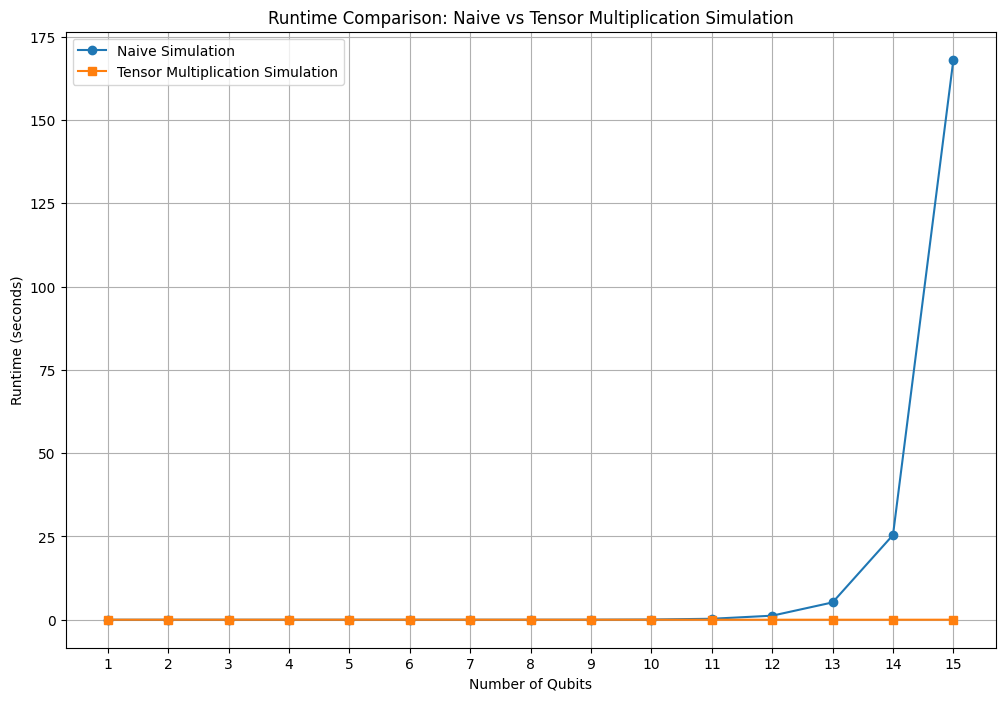

In [39]:
max_qubits = 15  # Adjust as needed based on your machine's capabilities
test_runtime_comparison(max_qubits)

### (3) Bonus question

#### 1. How would you sample from the final states in the statevector or tensor representations? 

In [ ]:
import numpy as np

def sample_statevector(statevector, num_samples=1):
    # Compute probabilities by taking the squared magnitude of each amplitude
    probabilities = np.abs(statevector) ** 2
    # Normalize probabilities to account for numerical precision
    probabilities /= probabilities.sum()
    # Generate all possible bitstrings
    n_qubits = int(np.log2(len(statevector)))
    bitstrings = [format(i, f'0{n_qubits}b') for i in range(len(statevector))]
    # Perform sampling
    samples = np.random.choice(bitstrings, size=num_samples, p=probabilities)
    return samples.tolist()

def sample_tensor(state_tensor, num_samples=1):
    # Flatten the tensor to a statevector
    statevector = state_tensor.flatten()
    return sample_statevector(statevector, num_samples)

In [14]:
# suppose we have a bell state |Φ+> = (|00> + |11>) / √2
bell_state = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=complex)

# sample from statevector
samples_sv = sample_statevector(bell_state, num_samples=10)
print("Samples from Statevector:", samples_sv)

# sample from tensor
bell_state_tensor = bell_state.reshape(2, 2)
samples_tensor = sample_tensor(bell_state_tensor, num_samples=10)
print("Samples from Tensor:", samples_tensor)

Samples from Statevector: ['11', '11', '00', '11', '11', '11', '00', '11', '00', '11']
Samples from Tensor: ['11', '00', '00', '00', '11', '11', '11', '00', '00', '00']


#### 2. And how about computing exact expectation values in the form <Ψ| Op |Ψ>?

In [ ]:
import numpy as np

def compute_expectation_statevector(statevector, operator):
    # Compute <Ψ| Op |Ψ>
    expectation = np.vdot(statevector, operator @ statevector)
    # Since operator is Hermitian, the result should be real
    return expectation.real

def compute_expectation_tensor(state_tensor, operator, n_qubits):
    # Flatten the tensor to a statevector
    statevector = state_tensor.flatten()
    return compute_expectation_statevector(statevector, operator)

In [ ]:
# Example: Expectation value of a Pauli-Z operator on a statevector and a tensor
# define Pauli-Z operator
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

# Z ⊗ I for 2 qubits
Z_I = np.kron(Z, I)

# suppose we have a state |00>
state_00 = np.array([1, 0, 0, 0], dtype=complex)
state_00_tensor = state_00.reshape(2, 2)

# compute expectation value ⟨00| Z ⊗ I |00⟩
expectation_sv = compute_expectation_statevector(state_00, Z_I)
print("Expectation value (Statevector):", expectation_sv)

expectation_tensor = compute_expectation_tensor(state_00_tensor, Z_I, n_qubits=2)
print("Expectation value (Tensor):", expectation_tensor)

# another example: Expectation value of Z⊗Z operator on a Bell state
bell_state = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=complex)
bell_state_tensor = bell_state.reshape(2, 2)

# compute expectation value ⟨Φ+| Z ⊗ Z |Φ+⟩
Z_Z = np.kron(Z, Z)
expectation_bell = compute_expectation_statevector(bell_state, Z_Z)
print("Expectation value for |Φ+> with Z⊗Z:", expectation_bell)

Expectation value (Statevector): 1.0
Expectation value (Tensor): 1.0
Expectation value for |Φ+> with Z⊗Z: 0.9999999999999998
